In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
ls *load*

biomag_download_info.ipynb  download_hcp_central.ipynb  download_output.txt


In [3]:
ls /mnt/hcp-meg/105923/

105923-head_mri-trans.fif        psd-broad-1-epo.fif
psd-alpha-0-epo.fif              psd-broad-1-spacing-ico4-stc.h5
psd-alpha-0-spacing-ico4-stc.h5  psd-broad-2-epo.fif
psd-alpha-1-epo.fif              psd-broad-2-spacing-ico4-stc.h5
psd-alpha-1-spacing-ico4-stc.h5  rest-run0-preproc-raw.fif
psd-alpha-2-epo.fif              rest-run1-preproc-raw.fif
psd-alpha-2-spacing-ico4-stc.h5  rest-run2-preproc-raw.fif
psd-broad-0-epo.fif              white-ico4-True-subject_on_fsaverage-fwd.fif
psd-broad-0-spacing-ico4-stc.h5  white-ico4-True-subject_on_fsaverage-src.fif


In [4]:
import copy as cp
import os.path as op
import mne

import matplotlib.pyplot as plt
import matplotlib

import seaborn as sns

import hcp
from hcp import preprocessing as preproc
from hcp import io

from scipy.signal import welch
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [5]:
%matplotlib inline

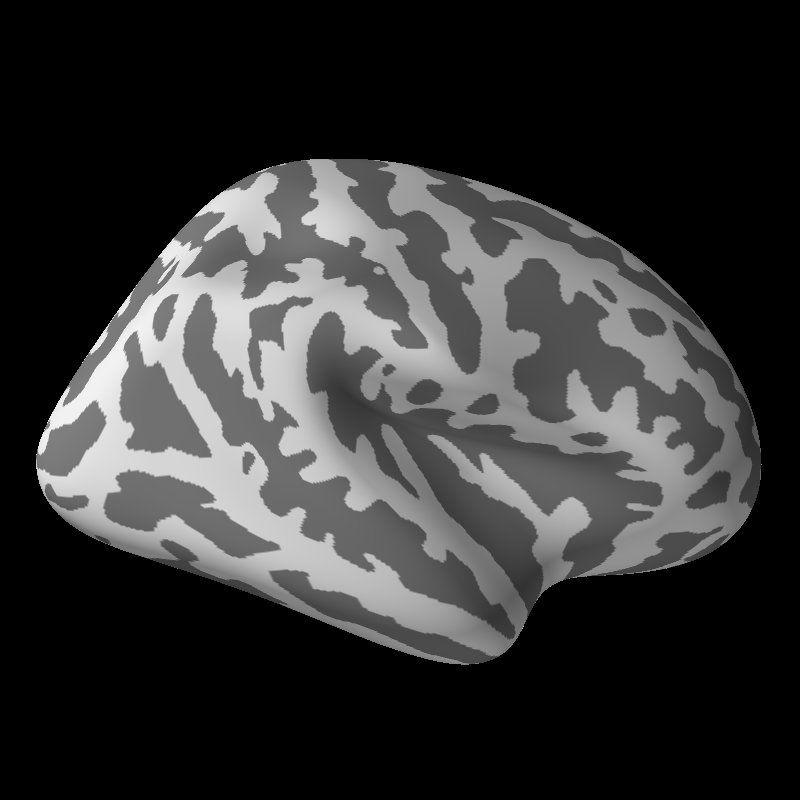

In [6]:
# # def nb_render_brain():
from IPython.display import Image
from mayavi import mlab
mlab.options.offscreen = True
from surfer import Brain
brain = Brain("fsaverage", "rh", "inflated", subjects_dir='/home/ubuntu/freesurfer/subjects')
brain.save_image('example2.png')
Image('example2.png')

In [7]:
sns.set_style('ticks')

In [8]:
matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica Neue') 
# matplotlib.rc('text', usetex='false') 

In [9]:
recordings_path = '/mnt/hcp-meg'
subject = '105923'

In [10]:
fname = op.join(recordings_path, subject, 'rest-run0-preproc-raw.fif')
raw = mne.io.read_raw_fif(fname)

Opening raw data file /mnt/hcp-meg/105923/rest-run0-preproc-raw.fif...
Isotrak not found
    Range : 0 ... 749069 =      0.000 ...   368.182 secs
Ready.
Current compensation grade : 0
Annotation expanding outside the data range. Limiting to the end of data.


<ipython-input-10-ec055da1a7b2>:2: RuntimeWarning: Annotation expanding outside the data range. Limiting to the end of data.
  raw = mne.io.read_raw_fif(fname)


In [11]:
raw.load_data()

Reading 0 ... 749069  =      0.000 ...   368.182 secs...


<Raw  |  rest-run0-preproc-raw.fif, n_channels x n_times : 248 x 749070 (368.2 sec), ~1.38 GB, data loaded>

In [12]:
%matplotlib inline

## works with with natural log

6.24416690066


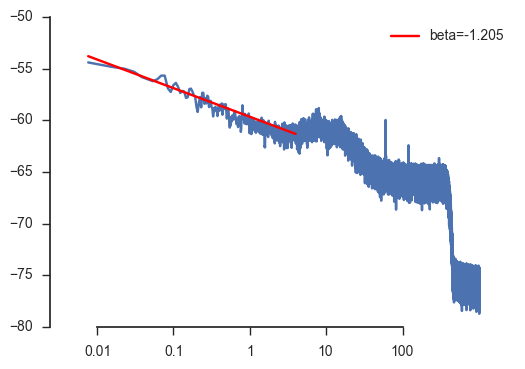

In [13]:
%matplotlib inline
freqs, psd = welch(raw[100][0], nperseg=(2**18), fs=raw.info['sfreq'], detrend='linear')
fmask = (freqs <= 4) & (freqs > 0)
lm = LinearRegression(normalize=False).fit(
   np.log(freqs[fmask][:, None]),
   np.log(psd.T[fmask]),
   )
frange = np.log(freqs[fmask].max()) - np.log(freqs[fmask].min())
print(frange)
plt.figure()
plt.plot(np.log(freqs), np.log(psd.T))
plt.plot(np.log(freqs[fmask][[0, -1]]),
         np.array([lm.intercept_,
                   lm.intercept_ + lm.coef_ * frange]) + frange, color='red',
         label='beta=%0.3f' % lm.coef_[0])
plt.legend(loc='best')
plt.xticks(np.log([0.01, 0.1, 1, 10, 100]),
                  [0.01, 0.1, 1, 10, 100])
sns.despine(trim=True)

## works with with decadic log

In [14]:
freqs, psd = welch(raw[100][0] * 1e15, nperseg=(2**18), fs=raw.info['sfreq'], detrend='linear', scaling='density')
    

In [ ]:
plt.plot(freqs[fmask])

In [213]:
fmask.sum()

4

/home/ubuntu/miniconda2/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10


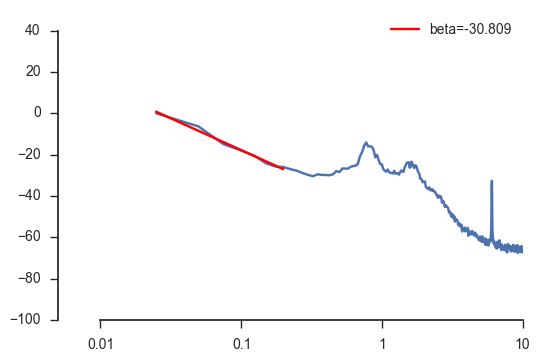

In [232]:
freqs, psd = welch(raw[100][0], nperseg=2**13, fs=raw.info['sfreq'], detrend='constant',
                   noverlap=2**10)
fmask = (freqs <= 2) & (freqs > 0)
freqs = np.log10(freqs)
psd /= psd[:, 1]
psd = 20 * np.log10(psd)
# psd = np.log10(psd)
lm = LinearRegression(normalize=False).fit(
   freqs[fmask][:, None],
   psd.T[fmask])

fit_line = lm.predict(freqs[fmask][:, None])
plt.figure()
plt.plot(freqs, psd.T)
plt.plot(freqs[fmask], fit_line, color='red', label='beta=%0.3f' % lm.coef_[0])
plt.legend(loc='best')
plt.xticks(np.log10([0.01, 0.1, 1, 10, 100]), [0.01, 0.1, 1, 10, 100])
plt.xlim(*np.log10([0.05, 100]))
plt.ylim(-100, 50)
sns.despine(trim=True)


## beta estimates as a function of window length

In [42]:
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error

In [ ]:
mean_squared_error(lm.predict(np.log10(freqs[fmask])[:, None]), np.log10(psd.T[fmask]))

In [ ]:
for exp in [12, 13, 14, 15, 16, 17, 18]:
    n_fft = 2 ** exp
    freqs, psd = welch(raw[100][0], nperseg=(n_fft), fs=raw.info['sfreq'], detrend='constant',
                       noverlap=0)
    fmask = (freqs <= 2) & (freqs > 0)
    lm = LinearRegression(normalize=False).fit(
       np.log10(freqs[fmask][:, None]),
       np.log10(psd.T[fmask]),
       )
    score = r2_score(
        lm.predict(np.log10(freqs[fmask])[:, None]), np.log10(psd.T[fmask]))
    frange = np.log10(freqs[fmask].max()) - np.log10(freqs[fmask].min())
    plt.figure()
    plt.plot(np.log10(freqs), np.log10(psd.T))
    fit_line = (lm.intercept_ - lm.coef_ * frange), lm.intercept_
    plt.plot(np.log10(freqs[fmask][[0, -1]]),
             fit_line, color='red',
             label='beta=%0.3f (nfft=%0.3f) r2=%0.3f' % (
                lm.coef_[0], 1. / raw.info['sfreq'] * n_fft, score))
    plt.legend(loc='best')
    plt.xticks(np.log10([0.01, 0.1, 1, 10, 100]), [0.1, 0.1, 1, 10, 100])
    sns.despine(trim=True)
    

## Use FFT without windowing

In [ ]:
(lm.intercept_ - (lm.coef_ * frange)), lm.intercept_

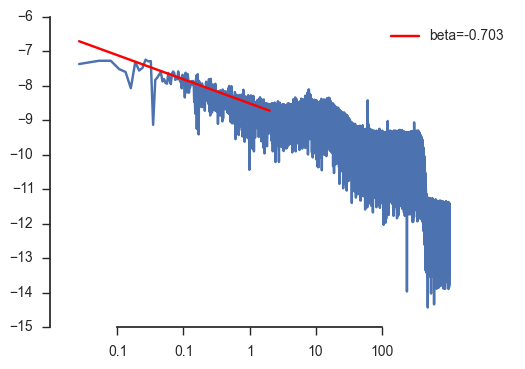

In [43]:
from scipy import fft, fftpack

freqs = fftpack.fftfreq(len(raw[100][0][0]), raw.times[1] - raw.times[0])
freqs = freqs[:freqs.size/2]

psd = fftpack.fft(raw[100][0][0])
psd = np.abs(psd[:psd.size/2][None, :])

fmask = (freqs <= 2) & (freqs > 0)
lm = LinearRegression(normalize=False).fit(
   np.log10(freqs[fmask][:, None]),
   np.log10(psd.T[fmask]),
   )
frange = np.log10(freqs[fmask].max()) - np.log10(freqs[fmask].min())
plt.figure()
plt.plot(np.log10(freqs), np.log10(psd.T))

fit_line = np.array([lm.intercept_,
                     lm.intercept_ + lm.coef_ * frange])
offset = np.abs(np.diff(fit_line.ravel()))[0]
plt.plot(np.log10(freqs[fmask][[0, -1]]),
         fit_line + offset, color='red',
         label='beta=%0.3f' % lm.coef_[0])
plt.legend(loc='best')
plt.xticks(np.log10([0.01, 0.1, 1, 10, 100]), [0.1, 0.1, 1, 10, 100])
sns.despine(trim=True)  

## an improved welch estimator

Use epoching functionality to get the good data segments, then apply windowing manually prior to FFT computation.
Shortcut: drop bad epochs, reconstruct raw data and then use the scipy function.

We see that with zero overlap the solutions are equivalent

In [44]:
n_fft = 2**15
duration = n_fft * (1. / raw.info['sfreq'])
events = mne.make_fixed_length_events(raw, 42, duration=duration)
epochs = mne.Epochs(raw, events=events, event_id=42, tmin=0,
                    tmax=duration, baseline=None, preload=True)

22 matching events found
No baseline correction applied
0 projection items activated
Loading data for 22 events and 32769 original time points ...
9 bad epochs dropped


In [45]:
raw2 = mne.io.RawArray(info=epochs.info, data=np.hstack(epochs.get_data()))

Creating RawArray with float64 data, n_channels=248, n_times=425997
Current compensation grade : 0
    Range : 0 ... 425996 =      0.000 ...   209.385 secs
Ready.


In [ ]:
print(raw.times.shape, raw2.times.shape)

In [46]:
psd1, freqs = mne.time_frequency.psd_welch(raw, n_fft=n_fft, picks=[100], n_overlap=0)
psd2, freqs = mne.time_frequency.psd_welch(raw2, n_fft=n_fft, picks=[100], n_overlap=0)
psd3_epochs, freqs = mne.time_frequency.psd_welch(epochs, n_fft=n_fft, picks=[100], n_overlap=0)
psd3 = psd3_epochs.mean(0)

Effective window size : 16.106 (s)
Effective window size : 16.106 (s)
Effective window size : 16.106 (s)


In [ ]:
ls paper_figures/

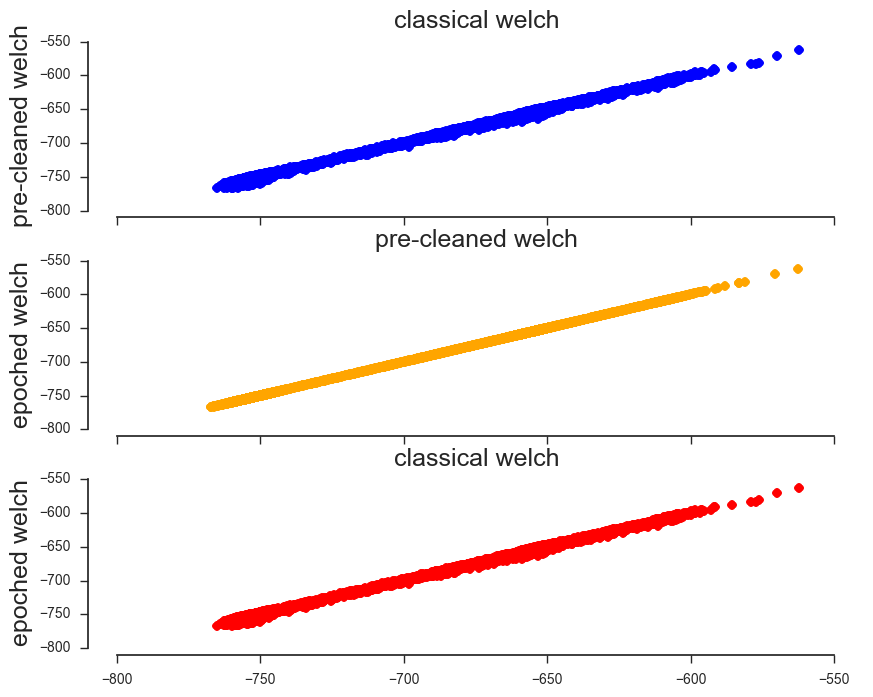

In [47]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 8))

fs = 18
axs[0].plot(10 * np.log(psd1.ravel()), 10 * np.log(psd2.ravel()),
            linewidth=0, marker='o', color='blue')
axs[0].set_title('classical welch', fontsize=fs)
axs[0].set_ylabel('pre-cleaned welch', fontsize=fs)

axs[1].plot(10 * np.log(psd3.ravel()), 10 * np.log(psd2.ravel()),
            linewidth=0, marker='o', color='orange')
axs[1].set_title('pre-cleaned welch', fontsize=fs)
axs[1].set_ylabel('epoched welch', fontsize=fs)

axs[2].plot(10 * np.log(psd1.ravel()), 10 * np.log(psd3.ravel()),
            linewidth=0, marker='o', color='red')

axs[2].set_title('classical welch', fontsize=fs)
axs[2].set_ylabel('epoched welch', fontsize=fs)
for ax in axs:
    ax.set_xlim(-810, -540)
    ax.set_ylim(-810, -540)
sns.despine(trim=True)

plt.show()
fig.savefig('paper_figures/check_welch_estimators.png', dpi=600)

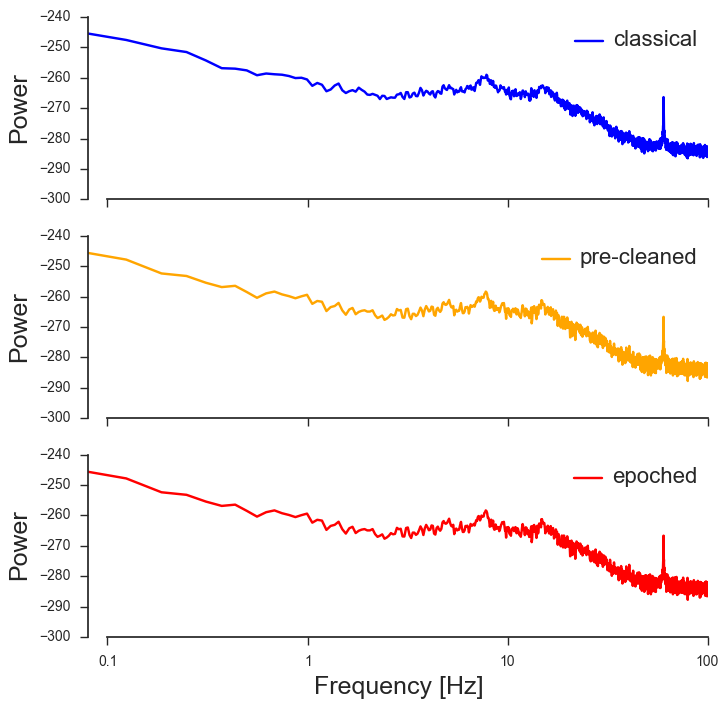

In [48]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(8, 8))

fs = 18
axs[0].plot(np.log10(freqs), 10 * np.log10(psd1).T, label='classical', color='blue')
axs[1].plot(np.log10(freqs), 10 * np.log10(psd2).T, label='pre-cleaned', color='orange')
axs[2].plot(np.log10(freqs), 10 * np.log10(psd3).T, label='epoched', color='red')
[[l.set_fontsize(16) for l in ax.legend().get_texts()] for ax in axs]
for ii, ax in enumerate(axs):
    if ii == 2:
        ax.set_xlabel('Frequency [Hz]', fontsize=fs)
    ax.set_ylabel('Power', fontsize=fs)
    ax.set_xticks(np.log10([0.1, 1, 10, 100]))
    ax.set_xticklabels([0.1, 1, 10, 100])
    ax.set_ylim(-300, -240)
    ax.set_xlim(np.log10(0.08), np.log10(100))

sns.despine(trim=True)
fig.savefig('paper_figures/check_welch_estimators_power.png', dpi=600)

In [ ]:
lm.coef_.mean()

In [ ]:
lm.intercept_.mean(), (lm.intercept_.mean() + lm.coef_.mean() * frange) + frange

In [ ]:
np.log10(freqs[fmask].max()) - np.log10(freqs[fmask].min())

In [ ]:
np.log10(freqs[fmask].max() - freqs[fmask].min())

In [ ]:
fit_line = np.array([lm.intercept_.mean(),
                         lm.intercept_.mean() + lm.coef_.mean() * frange])

In [ ]:
np.log10(freqs[fmask])

AttributeError: 'module' object has no attribute 'viridis'

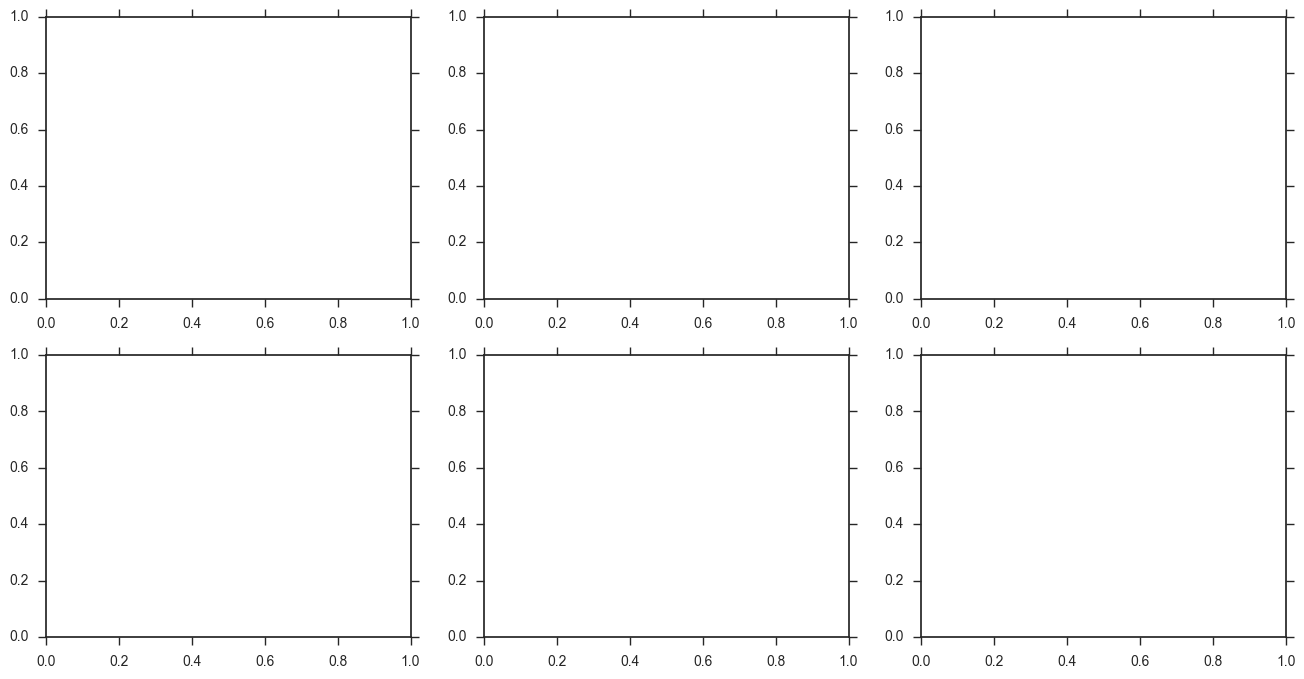

In [202]:
vals = list()

fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.ravel()

colors = [plt.cm.viridis(ii) for ii in
          np.linspace(0, 1, len(axes))]

for i_ax, (exp, ax, color) in enumerate(zip(
        [12, 13, 14, 15, 16, 17], axes, colors)):
    n_fft = 2 ** exp
    duration = n_fft * (1. / raw.info['sfreq'])
    events = mne.make_fixed_length_events(raw, 42, duration=duration)
    epochs = mne.Epochs(raw, events=events, event_id=42, tmin=0,
                        tmax=duration, baseline=None, preload=True)
    psd_epochs, freqs = mne.time_frequency.psd_welch(epochs, n_fft=n_fft, n_overlap=0)
    psd = 10 * np.log10(psd_epochs.mean(0))
    
    fmask = (freqs <= 2) & (freqs > 0)
    frange = np.log10(freqs[fmask].max()) - np.log10(freqs[fmask].min())
    
    lm = LinearRegression(normalize=False).fit(
       np.log10(freqs[fmask][:, None]), psd.T[fmask])
    scores = [r2_score(x, y) for x, y in zip(
              lm.predict(np.log10(freqs[fmask])[:, None]), psd.T[fmask])]
    vals.append((n_fft, scores, lm.coef_.ravel(), freqs[fmask][0]))
    psd_std = psd.std(0).T
    psd_mean = psd.mean(0).T
    
    ax.fill_between(np.log10(freqs), (psd_mean + psd_std).ravel(),
                                     (psd_mean - psd_std).ravel(),
                    color=color, alpha=0.3)
    ax.plot(np.log10(freqs), psd_mean, color=color,
            label='NFFT={}'.format(n_fft), linewidth=3)

    fit_line = lm.predict(np.log10(freqs[fmask][:, None])).mean(1)
    ax.plot(np.log10(freqs[fmask]),
             fit_line, color='red',
             label='beta=%0.3f (r2=%0.3f)' % (
                lm.coef_.mean(), np.mean(scores)),
            linewidth=2, linestyle='--')
    if i_ax in [3, 4, 5]:
        ax.set_xlabel('Frequency [Hz]', fontsize=18)
    if i_ax in [0, 3]:
        ax.set_ylabel('Power', fontsize=18)
    ax.set_xticks(np.log10([0.1, 1, 10, 100]))
    ax.set_xticklabels([0.1, 1, 10, 100])
    ax.set_xlim(np.log10(0.05), np.log10(100))
    ax.set_ylim(-295, -240)
    for tt in ax.legend(loc='lower left').get_texts():
        tt.set_fontsize(16)


sns.despine(trim=True)
fig.savefig('paper_figures/check_nfft_power_spectrum.png', dpi=600)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

bplots = [axs[0].boxplot([v[2] for v in vals]),
          axs[1].boxplot([v[1] for v in vals])]
axs[0].set_xticklabels([v[3].round(3) for v in vals], fontsize=14)
axs[1].set_xticklabels([v[3].round(3) for v in vals], fontsize=14)
axs[0].set_xlabel('Lowest frequency [Hz]', fontsize=20)
axs[1].set_xlabel('Lowest frequency [HZ]', fontsize=20)
axs[0].set_ylabel(r'powerlas exponent $\beta$ ', fontsize=20)
axs[1].set_ylabel(r'explained variance [$r^2$]', fontsize=20)
axs[0].set_xlim(0.5, 6.5)
axs[1].set_xlim(0.5, 6.5)
axs[1].set_ylim(-11, 1.5)


all_colors = [[plt.cm.viridis(ii) for ii in
               np.linspace(0, 1, len(vals))],
              [plt.cm.viridis(ii) for ii in
               np.linspace(0, 1, len(vals))]]

[axs[1].plot(42, 42, label='NFFT=%d' % v[0], color=c, marker='o')
 for v, c in zip(vals, all_colors[1])]
lg = axs[1].legend(loc='best')
[tt.set_fontsize(14) for tt in lg.get_texts()]

for bb, bplot in enumerate(bplots, 0):
    colors = all_colors[bb]
    for k, elems in bplot.items():
        for jj, el in enumerate(elems):
            if len(elems) == len(colors):
                this_colors = colors[:]
            else:
                this_colors = sum([[c, c] for c in colors], [])
            if hasattr(el, 'set_color'):
                el.set_color(this_colors[jj])
                el.set_linewidth(3)
sns.despine(trim=True)

fig.savefig('paper_figures/paper_fig_beta_est_choice.png', dpi=600)

## Checkout source localization and beta estimation

The firt task here will be to map the broadband signalfrom which we extract slow cortical potentials and the bandpass filtered hilbert alpha time course into source space such that memory does not explode and the corresponding powerlaw exponent can be computed.

We can stick with our epochs estimator here and map data epoch by epoch into the source space to then aggregate the data. Once this is done we can estimate powerlaw exponents all over the cortex without ROI-based approach.

The procedure is the same, whether we use the broadband data ore hilbert transformed data.
In the latter case the inverse operator will be applied to complex valued raw data.

### some concerns

- regularization parameter can have a strong impact on power estimates using MNE, the spatial SNR can be effectively much better than snr=1. Range 1-15 to be considered.
- covariance: frequency specific noise ... should probably match the signal projected.


In [50]:
raw_noise = hcp.read_raw(data_type='noise_empty_room', subject='105923', hcp_path='/mnt/HCP')

Reading 4D PDF file /mnt/HCP/105923/unprocessed/MEG/1-Rnoise/4D/c,rfDC...
Creating Neuromag info structure ...
... Setting channel info structure.
... no headshape file supplied, doing nothing.
Currently direct inclusion of 4D weight tables is not supported. For critical use cases please take into account the MNE command "mne_create_comp_data" to include weights as printed out by the 4D "print_table" routine.
Current compensation grade : 0


In [51]:
from scipy.signal.spectral import get_window

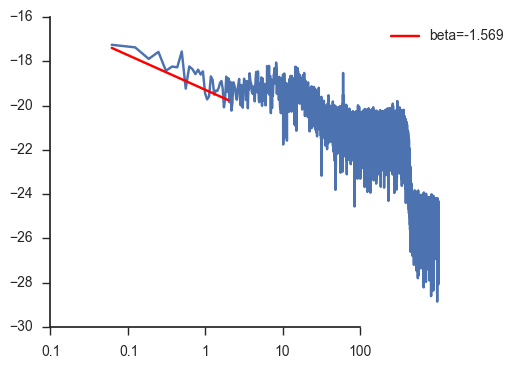

In [52]:
from scipy import fft, fftpack

x = raw[100][0][0]
n_samples = x.shape[-1]
# win = get_window('hanning', n_samples)

psd = fftpack.fft(x, n=2**15)

n_samples = psd.shape[-1]
freqs = fftpack.fftfreq(psd.shape[-1], raw.times[1] - raw.times[0])
psd = np.abs(psd[:psd.size/2][None, :]) ** 2
freqs = freqs[:freqs.size/2]

fmask = (freqs <= 2) & (freqs > 0)
lm = LinearRegression(normalize=False).fit(
   np.log10(freqs[fmask][:, None]),
   np.log10(psd.T[fmask]),
   )
frange = np.log10(freqs[fmask].max()) - np.log10(freqs[fmask].min())
plt.figure()
plt.plot(np.log10(freqs), np.log10(psd.T))
plt.plot(np.log10(freqs[fmask][[0, -1]]),
         np.array([lm.intercept_,
                   lm.intercept_ + lm.coef_ * frange]) + frange, color='red',
         label='beta=%0.3f' % lm.coef_[0])
plt.legend(loc='best')
plt.xticks(np.log10([0.01, 0.1, 1, 10, 100]), [0.1, 0.1, 1, 10, 100])
sns.despine(trim=True)  

## check how filter params drive alpha envelope slope

In [ ]:
ls

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.ravel()
n_fft = 2 ** 15
filtparams = [(7, 13), (8, 12), (9, 11)]
colors = [plt.cm.viridis(cc) for cc in np.linspace(0, 1, len(filtparams))] 
for ii, (fmin, fmax) in enumerate(filtparams):
    raw_hil = raw.copy().filter(fmin, fmax, picks=[100])
    raw_hil.apply_hilbert(picks=[100], envelope=True)
    freqs, psd = welch(raw_hil[100][0], nperseg=(n_fft), fs=raw_hil.info['sfreq'],
                       detrend='constant',
                       noverlap=0)
    duration = n_fft * (1. / raw.info['sfreq'])
    events = mne.make_fixed_length_events(raw, 42, duration=duration)
    epochs = mne.Epochs(raw_hil, events=events, event_id=42, tmin=0, picks=[100],
                        tmax=duration, baseline=None, preload=True)
    psd_epochs, freqs = mne.time_frequency.psd_welch(epochs, n_fft=n_fft, n_overlap=0)
    psd = psd_epochs.mean(0)
    axes[0].plot(np.log10(freqs), np.log10(psd.T),
                 color=colors[ii], label='{}-{}'.format(fmin, fmax), linewidth=3);
ax = axes[0]
for tt in ax.legend(loc='best').get_texts():
    tt.set_fontsize(18)
ax.set_xlabel('log(frequency)', fontsize=20)
ax.set_ylabel('power [dB]', fontsize=20)
ax.annotate('(A)', xy=(np.log10(0.1), -27), fontsize=24)
ax.set_xticks(np.log10([0.1, 1, 10, 100]))
ax.set_xticklabels([0.1, 1, 10, 100])
ax.set_xlim(np.log10(0.08), np.log10(100))

ax.set_ylim(-36, -25)

filtparams = [12, 13, 14, 15]
colors = [plt.cm.viridis(cc) for cc in np.linspace(0, 1, len(filtparams))] 
for ii, (exp) in enumerate(filtparams):
    raw_hil = raw.copy().filter(l_freq=8, h_freq=12, filter_length=2 ** exp, picks=[100])
    raw_hil.apply_hilbert(picks=[100], envelope=True)
    freqs, psd = welch(raw_hil[100][0], nperseg=(n_fft), fs=raw_hil.info['sfreq'],
                       detrend='constant',
                       noverlap=0)

    duration = n_fft * (1. / raw.info['sfreq'])
    events = mne.make_fixed_length_events(raw, 42, duration=duration)
    epochs = mne.Epochs(raw_hil, events=events, event_id=42, tmin=0, picks=[100],
                        tmax=duration, baseline=None, preload=True)
    psd_epochs, freqs = mne.time_frequency.psd_welch(epochs, n_fft=n_fft, n_overlap=0)
    psd = psd_epochs.mean(0)
    axes[1].plot(np.log10(freqs), np.log10(psd.T),
                 color=colors[ii], label='{}'.format(2**exp), linewidth=3);
ax = axes[1]
for tt in ax.legend(loc='best').get_texts():
    tt.set_fontsize(18)
ax.set_xlabel('log(frequency)', fontsize=20)
ax.set_ylabel('power [dB]', fontsize=20)
ax.set_xticks(np.log10([0.1, 1, 10, 100]))
ax.set_xticklabels([0.1, 1, 10, 100])
ax.set_xlim(np.log10(0.08), np.log10(100))
ax.set_ylim(-36, -25)
ax.annotate('(B)', xy=(np.log10(0.1), -27), fontsize=24)
sns.despine(trim=True)
fig.savefig('paper_figures/check_filter_params_on_alpha.png', dpi=600)

# Checkout peak estimation with kernels an diff trick

In [ ]:
n_fft = 2 ** 15
duration = n_fft * (1. / raw.info['sfreq'])
events = mne.make_fixed_length_events(raw, 42, duration=duration)
epochs = mne.Epochs(raw, events=events, event_id=42, tmin=0,
                    tmax=duration, baseline=None, preload=True)


In [ ]:
from astropy.convolution import convolve, Gaussian1DKernel

In [ ]:
np.log10(psd)

In [ ]:
(smoothed_data_gauss.T.shape, freqs.shape)

In [ ]:
n_fft = 2 ** 15
duration = n_fft * (1. / raw.info['sfreq'])
events = mne.make_fixed_length_events(raw, 42, duration=duration)
epochs = mne.Epochs(raw, events=events, event_id=42, tmin=0,
                    tmax=duration, baseline=None, preload=True)

psd_epochs, freqs = mne.time_frequency.psd_welch(epochs, n_fft=n_fft, n_overlap=0)
# psd = 10 * np.diff(np.log10(psd_epochs.mean(0)), 1, axis=-1)
# psd = 10 * np.diff(psd_epochs.mean(0), 1, axis=-1)
# psd = 10 * np.log10(psd_epochs.mean(0))
# gauss_kernel = Gaussian1DKernel(np.sum(freqs < 1))  # 0.5 Hz bandwidth

# smoothed_data_gauss = np.array([convolve(pp, gauss_kernel) for pp in psd])
# smoothed_data_gauss = convolve(psd[100], gauss_kernel)
# plt.plot(np.log10(freqs[1:]), psd.T, color='red')
# plt.plot(np.log10(freqs[1:],
#          smoothed_data_gauss.T, color='blue', alpha=0.01)
# plt.xlim(*np.log10([1, 50]))
# plt.xticks(np.log10([0.1, 1, 10]), [0.1, 1, 10])

In [ ]:
psd = 10 * np.log10(psd_epochs).mean(0)
k = np.sum(freqs < 0.1)
# k = 5
print(k)
gauss_kernel = Gaussian1DKernel(k)  # 0.5 Hz bandwidth
# smoothed_data_gauss = np.array([convolve(pp, gauss_kernel) for pp in np.diff(psd, axis=-1)])
smoothed_data_gauss = np.array([convolve(pp, gauss_kernel) for pp in psd])

plt.plot(freqs,
         smoothed_data_gauss.T, color='blue', alpha=.1);
plt.xlim([1, 30])
# plt.xlim(*np.log10([1, 100]))
# plt.xticks(np.log10([0.1, 1, 10, 100]), [0.1, 1, 10, 100])

In [ ]:
smoothed_data_gauss[:, freqs < 200]

In [ ]:
fmask = (freqs < 15) * (freqs > 7)
peaks = np.array([freqs[fmask][ii] for ii in
                  np.argmax(smoothed_data_gauss[:, fmask], 1)])
peaks = mne.EvokedArray(info=cp.deepcopy(raw.info), data=peaks[:, None], tmin=0)
hcp.preprocessing.map_ch_coords_to_mne(peaks)
peaks.plot_topomap([0], scale=1, cmap='viridis', vmin=np.min, vmax=np.max,
                   unit='Hz', size=4, contours=0);

# Try whitening

In [ ]:
from mne.time_frequency import fit_iir_model_raw
from scipy import signal

In [ ]:
x = raw[100][0][0].ravel()
order = 5
b, a = fit_iir_model_raw(raw, order=order, picks=[100])

In [ ]:
innovation = signal.convolve(x, a, 'valid')
# x_ = np.r_[x_[0] * np.intones(order), x_]  # dummy samples to keep signal length

In [ ]:
x_ = signal.lfilter(x, a, innovation)  # regenerate the signal

# checkout new inverse workflow

In [53]:
from mne.minimum_norm import apply_inverse_epochs, make_inverse_operator

subject = '105923'
subjects_dir = '/mnt/hcp_subjects'
recordings_path = '/mnt/hcp-meg/'
hcp_path = '/mnt/HCP'

In [54]:
raw_noise = hcp.read_raw(data_type='noise_empty_room', subject=subject, hcp_path=hcp_path)

raw_noise.load_data()
preproc.apply_ref_correction(raw_noise)
raw_noise.pick_types(meg=True, ref_meg=False)

noise_cov = mne.compute_raw_covariance(raw_noise, method='empirical')

Reading 4D PDF file /mnt/HCP/105923/unprocessed/MEG/1-Rnoise/4D/c,rfDC...
Creating Neuromag info structure ...
... Setting channel info structure.
... no headshape file supplied, doing nothing.
Currently direct inclusion of 4D weight tables is not supported. For critical use cases please take into account the MNE command "mne_create_comp_data" to include weights as printed out by the 4D "print_table" routine.
Current compensation grade : 0
Reading 0 ... 610353  =      0.000 ...   300.000 secs...
Using up to 1500 segments
Number of samples used : 610500
[done]


In [ ]:
hcp.make_mne_anatomy(subject=subject, subjects_dir=subjects_dir, recordings_path=recordings_path, hcp_path=hcp_path)

In [ ]:
# %%bash
# cp -R /home/ubuntu/freesurfer/subjects/fsaverage /mnt/hcp_subjects/
# ls /mnt/hcp_subjects/

In [61]:
stack = hcp.compute_forward_stack(
    subject=subject, subjects_dir=subjects_dir,
    src_params=dict(spacing='ico4'),
    hcp_path=hcp_path, recordings_path=recordings_path)

Setting up the source space with the following parameters:

SUBJECTS_DIR = /mnt/hcp_subjects
Subject      = fsaverage
Surface      = white
Icosahedron subdivision grade 4

>>> 1. Creating the source space...

Doing the icosahedral vertex picking...
Loading /mnt/hcp_subjects/fsaverage/surf/lh.white...
    Triangle neighbors and vertex normals...
Loading geometry from /mnt/hcp_subjects/fsaverage/surf/lh.sphere...
    Triangle neighbors and vertex normals...
Mapping lh fsaverage -> ico (4) ...
Setting up the triangulation for the decimated surface...
loaded lh.white 2562/163842 selected to source space (ico = 4)

Loading /mnt/hcp_subjects/fsaverage/surf/rh.white...
    Triangle neighbors and vertex normals...
Loading geometry from /mnt/hcp_subjects/fsaverage/surf/rh.sphere...
    Triangle neighbors and vertex normals...
Mapping rh fsaverage -> ico (4) ...
Setting up the triangulation for the decimated surface...
loaded rh.white 2562/163842 selected to source space (ico = 4)

You are now o

In [59]:
from mne.time_frequency.psd import _psd_welch




def _compute_source_psd(raw, noise_cov, fwd, n_fft=2 ** 15, method='MNE',lambda2=1./1.**2., decim=1,
                        fmax=150):
    inv_op = make_inverse_operator(
        info=raw.info, forward=fwd, noise_cov=noise_cov, loose=0.2, depth=0.8,
        fixed=False, limit_depth_chs=True, rank=None, verbose=None)

    duration = n_fft * (1. / raw.info['sfreq'])
    events = mne.make_fixed_length_events(raw, 42, duration=duration)
    epochs = mne.Epochs(raw, events=events, event_id=42, tmin=0,
                        tmax=duration, baseline=None, preload=True, decim=decim)
    if np.iscomplexobj(epochs.get_data()):
        print('computing the envelope')
        epochs._data = np.abs(epochs.get_data())

    stc_gen = apply_inverse_epochs(
        epochs, inv_op, lambda2=lambda2, method=method, label=None, nave=1, pick_ori='normal',
        return_generator=False, prepared=False, verbose=None)
    
    psd_src = 0.
    for ii, this_stc in enumerate(stc_gen, 1):
        psd, freqs = _psd_welch(this_stc.data, epochs.info['sfreq'], fmin=0, fmax=fmax,
                                n_fft=n_fft, n_overlap=0, n_jobs=1)
        psd_src += psd
    psd_src /= ii

    stc_psd = this_stc
    stc_psd._data = psd_src
    stc_psd.times = freqs 
    return stc_psd

In [32]:
mne.utils.set_log_level('warning')

In [33]:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15][::3]

[1, 4, 7, 10, 13]

In [19]:
def clean_psd(psd, freqs, normalize=True, dB=20):
    psd = psd[:, freqs > 0]
    freqs = freqs[freqs > 0]
    # inplace on psd gives bug
    psd = dB * np.log10(psd / psd[:, 0:1] if normalize else psd)
    return psd, freqs

22 matching events found
No baseline correction applied
0 projection items activated
Loading data for 22 events and 32769 original time points ...
9 bad epochs dropped
Effective window size : 16.106 (s)
    Converting to surface-based source orientations...
    Average patch normals will be employed in the rotation to the local surface coordinates....
[done]
info["bads"] and noise_cov["bads"] do not match, excluding bad channels from both
Computing inverse operator with 245 channels.
estimated rank (mag): 245
Setting small MEG eigenvalues to zero.
Not doing PCA for MEG.
Total rank is 245
Creating the depth weighting matrix...
    245 magnetometer or axial gradiometer channels
    limit = 5066/5124 = 10.006278
    scale = 8.65398e-11 exp = 0.8
Computing inverse operator with 245 channels.
Creating the source covariance matrix
Applying loose dipole orientations. Loose value of 0.2.
Whitening the forward solution.
Adjusting source covariance matrix.
Computing SVD of whitened and weighted 

<ipython-input-59-291294984a16>:15: RuntimeWarning: The measurement information indicates a low-pass frequency of 1017.26 Hz. The decim=3 parameter will result in a sampling frequency of 678.17 Hz, which can cause aliasing artifacts.
  tmax=duration, baseline=None, preload=True, decim=decim)


9 bad epochs dropped
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a full noise covariance matrix (0 small eigenvalues omitted)
Picked 245 channels from the data
Computing inverse...
(eigenleads need to be weighted)...
Processing epoch : 1
Processing epoch : 2
Processing epoch : 3
Processing epoch : 4
Processing epoch : 5
Processing epoch : 6
Processing epoch : 7
Processing epoch : 8
Processing epoch : 9
Processing epoch : 10
Processing epoch : 11
Processing epoch : 12
Processing epoch : 13
[done]
Effective window size : 16.107 (s)
Effective window size : 16.107 (s)
Effective window size : 16.107 (s)
Effective window size : 16.107 (s)
Effective window size : 16.107 (s)
Effective window size : 16.107 (s)
Effective window size : 16.107 (s)
Effective window size : 16.107 (s)
Effective window size : 16.10

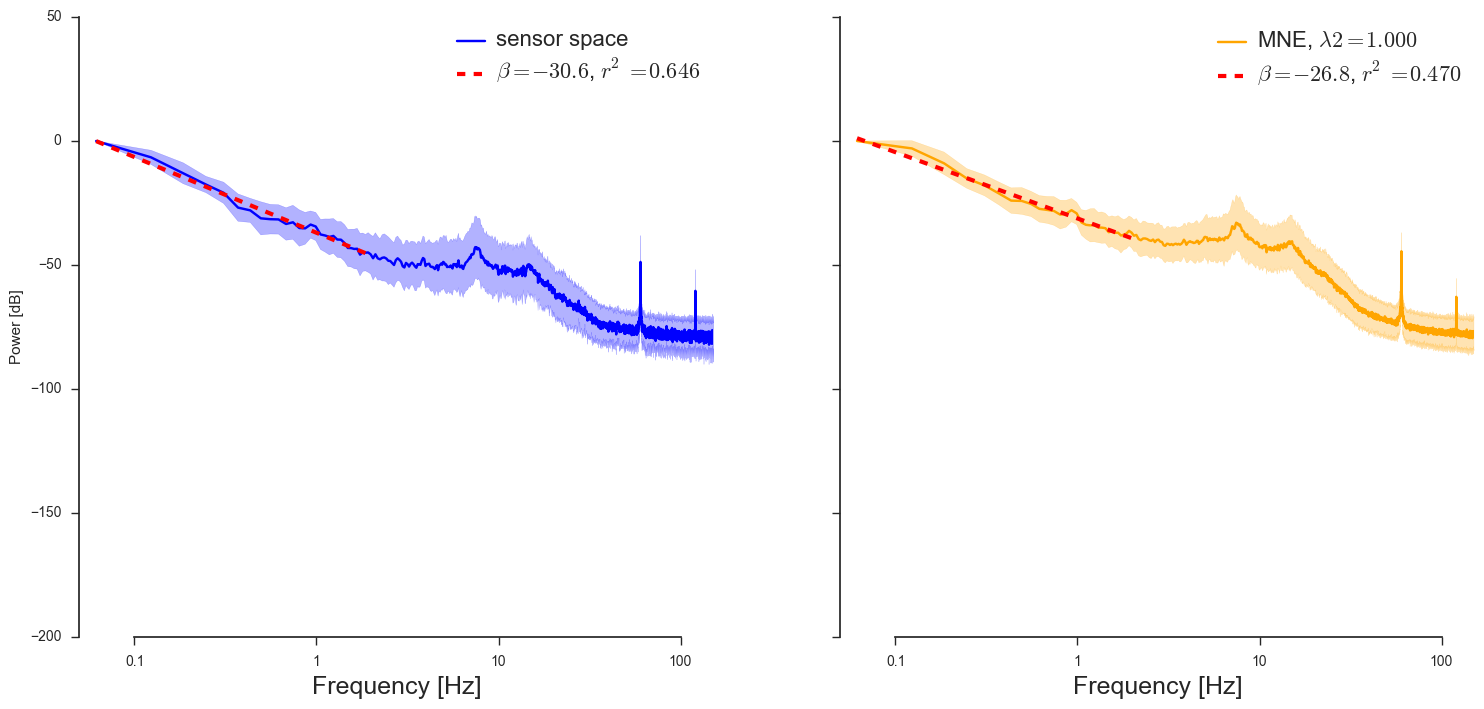

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharex=True, sharey=True)
axes = axes.ravel()
n_fft = 2 ** 15
decim = 1
duration = n_fft * (1. / raw.info['sfreq'])
events = mne.make_fixed_length_events(raw, 42, duration=duration)
epochs = mne.Epochs(raw, events=events, event_id=42, tmin=0,
                    tmax=duration, baseline=None, preload=True, decim=decim)

psd_epochs, freqs = mne.time_frequency.psd_welch(epochs, n_fft=n_fft, n_overlap=0)

psd = psd_epochs.mean(0)

psd, freqs = clean_psd(psd, freqs)

psd_mean = psd.mean(0)
psd_std = psd.std(0)

fmask = (freqs > 0) & (freqs < 2)


ax = axes[0]
ax.plot(np.log10(freqs), psd_mean, label='sensor space', color='blue')
ax.fill_between(np.log10(freqs),
                 psd_mean + psd_std,
                 psd_mean - psd_std, alpha=0.3, color='blue')

lm = LinearRegression(normalize=False).fit(
   np.log10(freqs[fmask][:, None]), psd.T[fmask])
scores = [r2_score(x, y) for x, y in zip(
          lm.predict(np.log10(freqs[fmask])[:, None]), psd.T[fmask])]
fit_line = lm.predict(np.log10(freqs[fmask][:, None])).mean(1)
ax.plot(np.log10(freqs[fmask]), fit_line, color='red', linewidth=3,
        linestyle='--', label=r"$\beta=%0.1f$, $r^2=%0.3f$" % (
            lm.coef_.ravel().mean(0), np.mean(scores)))

ax.set_xlim(*np.log10([0.05, 150]))
ax.set_xticks(np.log10([0.1, 1, 10, 100]))
ax.set_xticklabels([0.1, 1, 10, 100])
for tt in ax.legend().get_texts():
    tt.set_fontsize(16)


lambda2 = 1.
stc_psd = _compute_source_psd(
    raw, noise_cov=noise_cov, fwd=stack['fwd'], method='MNE',
    lambda2=lambda2, decim=3)

freqs = stc_psd.times
psd = stc_psd.data
psd, freqs = clean_psd(psd, freqs)
psd_mean = psd.mean(0)
psd_std = psd.std(0)

ax = axes[1]

ax.plot(np.log10(freqs), psd_mean, label=r"MNE, $\lambda2=%0.3f$" % lambda2, color='orange')
ax.fill_between(np.log10(freqs),
                 psd_mean + psd_std,
                 psd_mean - psd_std, alpha=0.3, color='orange')

fmask = (freqs > 0) & (freqs < 2)
lm = LinearRegression(normalize=False).fit(
   np.log10(freqs[fmask][:, None]), psd.T[fmask])
scores = np.array([r2_score(x, y) for x, y in zip(
          lm.predict(np.log10(freqs[fmask])[:, None]), psd.T[fmask])])
fit_line = lm.predict(np.log10(freqs[fmask][:, None])).mean(1)
ax.plot(np.log10(freqs[fmask]), fit_line, color='red', linewidth=3,
        linestyle='--', label=r"$\beta=%0.1f$, $r^2=%0.3f$" % (
            lm.coef_.ravel().mean(0), np.mean(scores)))

ax.set_xlim(*np.log10([0.05, 150]))
ax.set_xticks(np.log10([0.1, 1, 10, 100]))
ax.set_xticklabels([0.1, 1, 10, 100])
for tt in ax.legend().get_texts():
    tt.set_fontsize(16)

axes[0].set_ylabel('Power [dB]')
axes[0].set_xlabel('Frequency [Hz]', fontsize=18)
axes[1].set_xlabel('Frequency [Hz]', fontsize=18)

sns.despine(trim=True)

fig.savefig('paper_figures/compare_sensor_sources_broadband.png', dpi=600)

In [90]:
# %timeit lm = LinearRegression(normalize=False).fit(np.log10(freqs[fmask][:, None]), psd.T[fmask])
%timeit scores = np.array([r2_score(x, y) for x, y in zip(lm.predict(np.log10(freqs[fmask])[:, None]), psd.T[fmask])])


100 loops, best of 3: 6.16 ms per loop


In [91]:
%timeit fit_line = lm.predict(np.log10(freqs[fmask][:, None])).mean(1)


1000 loops, best of 3: 547 µs per loop


In [63]:
stc_broad = stc_psd.copy()
stc_broad._data = psd
stc_broad.times = freqs
stc_broad_slope = stc_broad.copy()
stc_broad_slope.times = np.array([0])
stc_broad_slope._data = lm.coef_

Setting up band-pass filter from 8 - 12 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 3.0 Hz
Filter length of 6714 samples (3.300 sec) selected
22 matching events found
No baseline correction applied
0 projection items activated
Loading data for 22 events and 32769 original time points ...
9 bad epochs dropped
Effective window size : 16.106 (s)
    Converting to surface-based source orientations...
    Average patch normals will be employed in the rotation to the local surface coordinates....
[done]
info["bads"] and noise_cov["bads"] do not match, excluding bad channels from both
Computing inverse operator with 245 channels.
estimated rank (mag): 245
Setting small MEG eigenvalues to zero.
Not doing PCA for MEG.
Total rank is 245
Creating the depth weighting matrix...
    245 magnetometer or axial gradiometer channels
    limit = 5066/5124 = 10.006278
    scale = 8.65398e-11 exp = 0.8
Computing inverse operator with 245 channels.
Creating the source covariance 

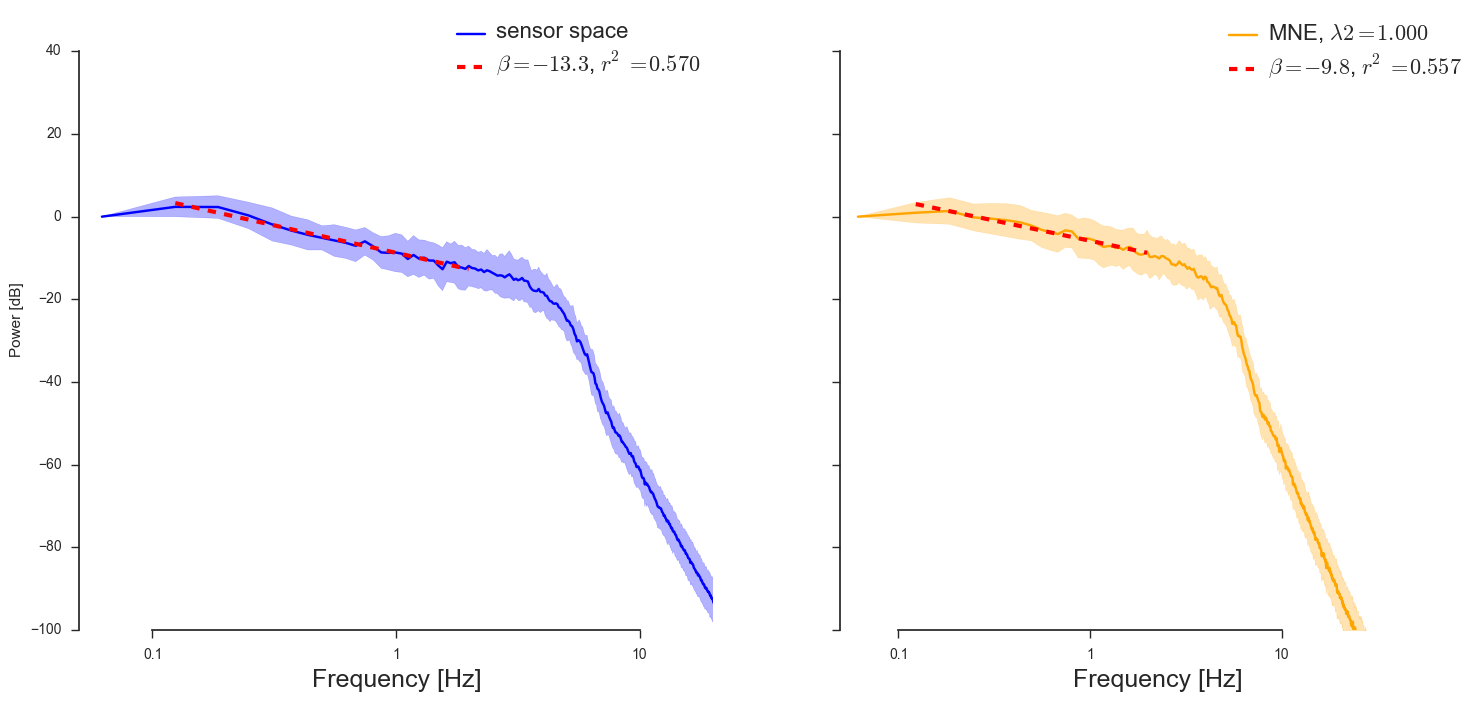

In [64]:
raw_hil = raw.copy().filter(8, 12)
raw_hil.apply_hilbert(picks=list(range(248)), envelope=False)

fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharex=True, sharey=True)
axes = axes.ravel()

n_fft = 2 ** 15
decim = 1
duration = n_fft * (1. / raw_hil.info['sfreq'])
events = mne.make_fixed_length_events(raw, 42, duration=duration)
epochs = mne.Epochs(raw_hil, events=events, event_id=42, tmin=0,
                    tmax=duration, baseline=None, preload=True, decim=decim)
epochs._data = np.abs(epochs.get_data())
psd_epochs, freqs = mne.time_frequency.psd_welch(epochs, n_fft=n_fft, n_overlap=0)

psd = psd_epochs.mean(0)

psd, freqs = clean_psd(psd, freqs)

psd_mean = psd.mean(0)
psd_std = psd.std(0)

fmask = (freqs >= 0.1) & (freqs < 2)


ax = axes[0]
ax.plot(np.log10(freqs), psd_mean, label='sensor space', color='blue')
ax.fill_between(np.log10(freqs),
                 psd_mean + psd_std,
                 psd_mean - psd_std, alpha=0.3, color='blue')

lm = LinearRegression(normalize=False).fit(
   np.log10(freqs[fmask][:, None]), psd.T[fmask])
scores = [r2_score(x, y) for x, y in zip(
          lm.predict(np.log10(freqs[fmask])[:, None]), psd.T[fmask])]
fit_line = lm.predict(np.log10(freqs[fmask][:, None])).mean(1)
ax.plot(np.log10(freqs[fmask]), fit_line, color='red', linewidth=3,
        linestyle='--', label=r"$\beta=%0.1f$, $r^2=%0.3f$" % (
            lm.coef_.ravel().mean(0), np.mean(scores)))

ax.set_xlim(*np.log10([0.05, 20]))
ax.set_xticks(np.log10([0.1, 1, 10, 100]))
ax.set_xticklabels([0.1, 1, 10, 100])
for tt in ax.legend().get_texts():
    tt.set_fontsize(16)


lambda2 = 1.
stc_psd = _compute_source_psd(
    raw_hil, noise_cov=noise_cov, fwd=stack['fwd'], method='MNE',
    lambda2=lambda2, decim=3, fmax=50)

freqs = stc_psd.times
psd = stc_psd.data
psd, freqs = clean_psd(psd, freqs)
psd_mean = psd.mean(0)
psd_std = psd.std(0)

ax = axes[1]

ax.plot(np.log10(freqs), psd_mean, label=r"MNE, $\lambda2=%0.3f$" % lambda2, color='orange')
ax.fill_between(np.log10(freqs),
                 psd_mean + psd_std,
                 psd_mean - psd_std, alpha=0.3, color='orange')

fmask = (freqs >= 0.1) & (freqs < 2)
lm = LinearRegression(normalize=False).fit(
   np.log10(freqs[fmask][:, None]), psd.T[fmask])
scores = np.array([r2_score(x, y) for x, y in zip(
          lm.predict(np.log10(freqs[fmask])[:, None]), psd.T[fmask])])
fit_line = lm.predict(np.log10(freqs[fmask][:, None])).mean(1)
ax.plot(np.log10(freqs[fmask]), fit_line, color='red', linewidth=3,
        linestyle='--', label=r"$\beta=%0.1f$, $r^2=%0.3f$" % (
            lm.coef_.ravel().mean(0), np.mean(scores)))

ax.set_xlim(*np.log10([0.05, 20]))
ax.set_xticks(np.log10([0.1, 1, 10, 100]))
ax.set_xticklabels([0.1, 1, 10, 100])
for tt in ax.legend().get_texts():
    tt.set_fontsize(16)

axes[0].set_ylabel('Power [dB]')
axes[0].set_xlabel('Frequency [Hz]', fontsize=18)
axes[1].set_xlabel('Frequency [Hz]', fontsize=18)
axes[0].set_ylim(-100, 50)
axes[1].set_ylim(-100, 50)
sns.despine(trim=True)

fig.savefig('paper_figures/compare_sensor_sources_alpha_env.png', dpi=600)

In [65]:
stc_alpha = stc_psd.copy()
stc_alpha._data = psd
stc_alpha.times = freqs
stc_alpha_slope = stc_alpha.copy()
stc_alpha_slope.times = np.array([0])
stc_alpha_slope._data =  np.abs(lm.coef_)

In [75]:
stc_broad_slope.plot?

In [69]:
from IPython.display import Image

In [66]:
from hcp_central import colormaps as cmaps

for key, val in cmaps.cmaps.items():
    plt.register_cmap(name=key, cmap=val)


In [67]:
stc_broad_slope._data =  np.abs(stc_broad_slope.data)

Updating smoothing matrix, be patient..
Smoothing matrix creation, step 1
Smoothing matrix creation, step 2
Smoothing matrix creation, step 3
Smoothing matrix creation, step 4
Smoothing matrix creation, step 5
Smoothing matrix creation, step 6
Smoothing matrix creation, step 7
Smoothing matrix creation, step 8
Smoothing matrix creation, step 9
Smoothing matrix creation, step 10
colormap: fmin=1.82e+01 fmid=2.64e+01 fmax=3.63e+01 transparent=0
Updating smoothing matrix, be patient..
Smoothing matrix creation, step 1
Smoothing matrix creation, step 2
Smoothing matrix creation, step 3
Smoothing matrix creation, step 4
Smoothing matrix creation, step 5
Smoothing matrix creation, step 6
Smoothing matrix creation, step 7
Smoothing matrix creation, step 8
Smoothing matrix creation, step 9
Smoothing matrix creation, step 10
colormap: fmin=1.82e+01 fmid=2.64e+01 fmax=3.63e+01 transparent=0


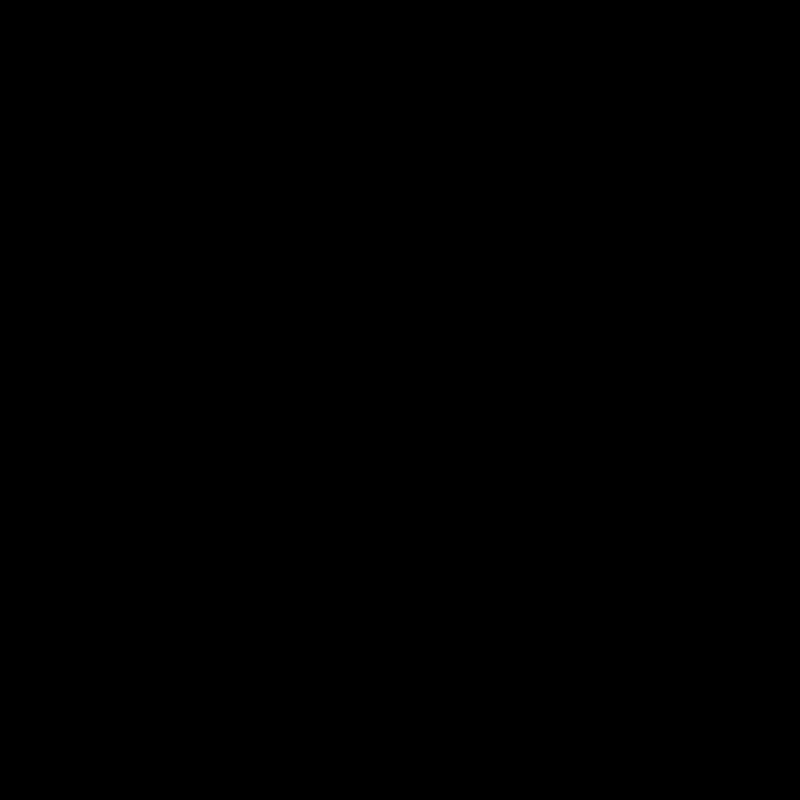

In [70]:
brain = stc_broad_slope.plot(subject=subject, subjects_dir=subjects_dir,
                             hemi='both',
                             time_label='slope (SCP)',
                             transparent=False,
                             clim=dict(kind='percent', lims=[1, 50, 99]),
                             colormap=cmaps.viridis.colors)
brain.show_view('dorsal')
brain.save_image('paper_figures/scp_slope_subject_demo.png')
Image('paper_figures/scp_slope_subject_demo.png')

Updating smoothing matrix, be patient..
Smoothing matrix creation, step 1
Smoothing matrix creation, step 2
Smoothing matrix creation, step 3
Smoothing matrix creation, step 4
Smoothing matrix creation, step 5
Smoothing matrix creation, step 6
Smoothing matrix creation, step 7
Smoothing matrix creation, step 8
Smoothing matrix creation, step 9
Smoothing matrix creation, step 10
colormap: fmin=2.29e+00 fmid=9.37e+00 fmax=1.84e+01 transparent=0
Updating smoothing matrix, be patient..
Smoothing matrix creation, step 1
Smoothing matrix creation, step 2
Smoothing matrix creation, step 3
Smoothing matrix creation, step 4
Smoothing matrix creation, step 5
Smoothing matrix creation, step 6
Smoothing matrix creation, step 7
Smoothing matrix creation, step 8
Smoothing matrix creation, step 9
Smoothing matrix creation, step 10
colormap: fmin=2.29e+00 fmid=9.37e+00 fmax=1.84e+01 transparent=0


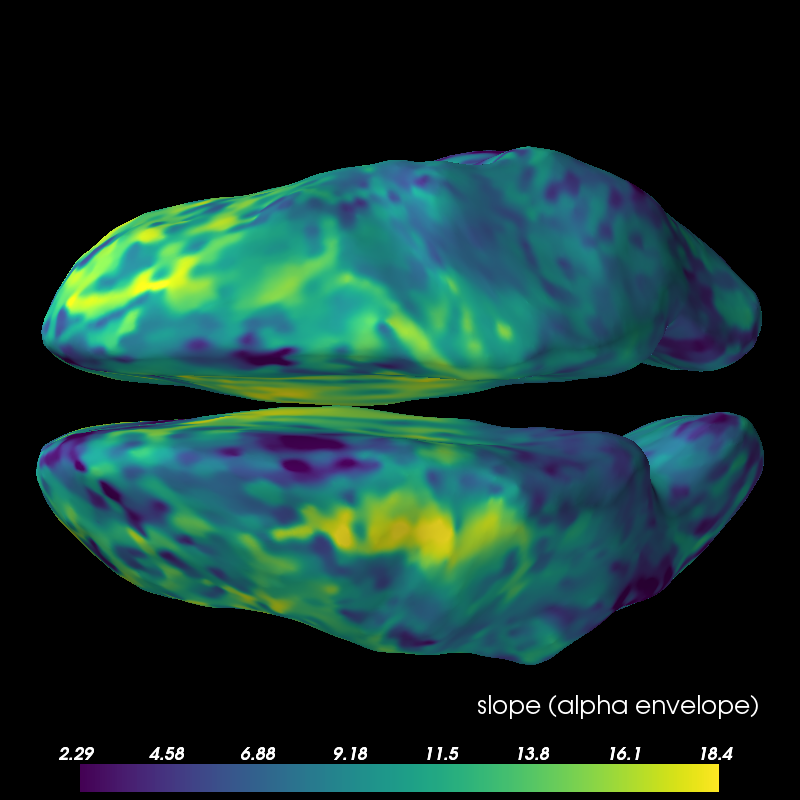

In [98]:
brain = stc_alpha_slope.plot(subject=subject, subjects_dir=subjects_dir,
                             hemi='both',
                             time_label='slope (alpha envelope)',
                             transparent=False,
                             clim=dict(kind='percent', lims=[1, 50, 99]),
                             colormap=cmaps.viridis.colors)
brain.show_view('dorsal')
brain.save_image('paper_figures/alpha_slope_subject_demo.png')
Image('paper_figures/alpha_slope_subject_demo.png')

# Regularization parameter.

In [ ]:
for this_l in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15][::3]:
    lambda2 = 1./this_l **2
    stc_psd = _compute_source_psd(raw, noise_cov=noise_cov, fwd=stack['fwd'], method='dSPM', lambda2=lambda2,
                                  decim=3)

    # plt.plot(np.log10(stc_psd.times), np.log10(stc_psd.data[::10].T));

    psd_mean = np.log10(stc_psd.data).mean(0)
    plt.figure()
    plt.plot(np.log10(stc_psd.times), psd_mean, label='lambda2 %0.3f' % lambda2)
    psd_std = np.log10(stc_psd.data).std(0)
    plt.fill_between(np.log10(stc_psd.times),
                     psd_mean + psd_std,
                     psd_mean - psd_std, alpha=0.3)
    plt.xlim(*np.log10([0.1, 150]))
    plt.xticks(np.log10([0.1, 1, 10, 100]), [0.1, 1, 10, 100])
    plt.legend()


In [ ]:
psd_mean.shape

In [ ]:
stc_psd = compute_source_psd(raw, noise_cov=noise_cov, fwd=stack['fwd'], method='MNE')

psd_mean = np.log10(stc_psd.data).mean(0)
plt.plot(np.log10(stc_psd.times), psd_mean)
psd_std = np.log10(stc_psd.data).std(0)
plt.fill_between(np.log10(stc_psd.times),
                 psd_mean + psd_std,
                 psd_mean - psd_std, alpha=0.3)


## Median split power

In [156]:
n_fft = 2 ** 15
decim = 1
duration = n_fft * (1. / raw.info['sfreq'])
events = mne.make_fixed_length_events(raw, 42, duration=duration)
epochs = mne.Epochs(raw, events=events, event_id=42, tmin=0,
                    tmax=duration, baseline=None, preload=True, decim=decim)

psd_epochs, freqs = mne.time_frequency.psd_welch(epochs, n_fft=n_fft, n_overlap=0)
fmask = (freqs >= 8) & (freqs <= 12)


22 matching events found
No baseline correction applied
0 projection items activated
Loading data for 22 events and 32769 original time points ...
8 bad epochs dropped
Effective window size : 16.106 (s)


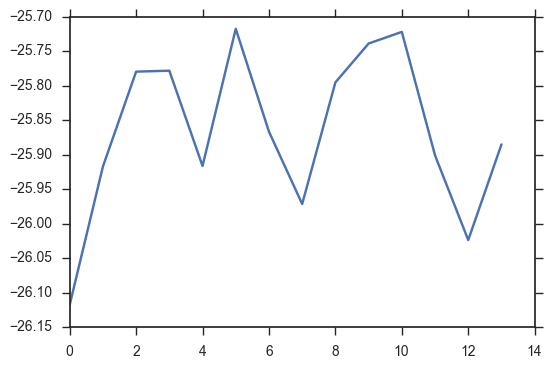

In [165]:
means = np.log10(psd_epochs[:, :,  fmask].max(-1).mean(1))
med = np.median(means)
up_state = means >= med
down_state = np.invert(up_state)
plt.plot(means)

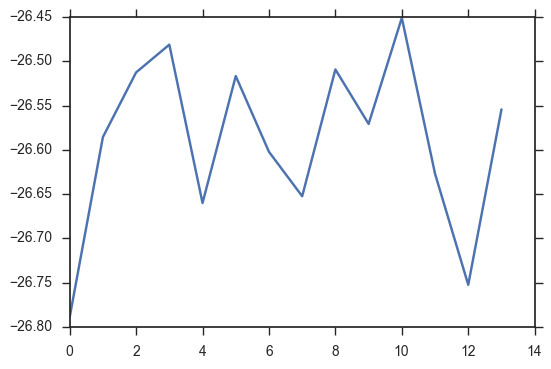

7 matching events found
No baseline correction applied
0 projection items activated
Loading data for 7 events and 32769 original time points ...
2 bad epochs dropped
Effective window size : 16.106 (s)
6 matching events found
No baseline correction applied
0 projection items activated
Loading data for 6 events and 32769 original time points ...
4 bad epochs dropped
Effective window size : 16.106 (s)


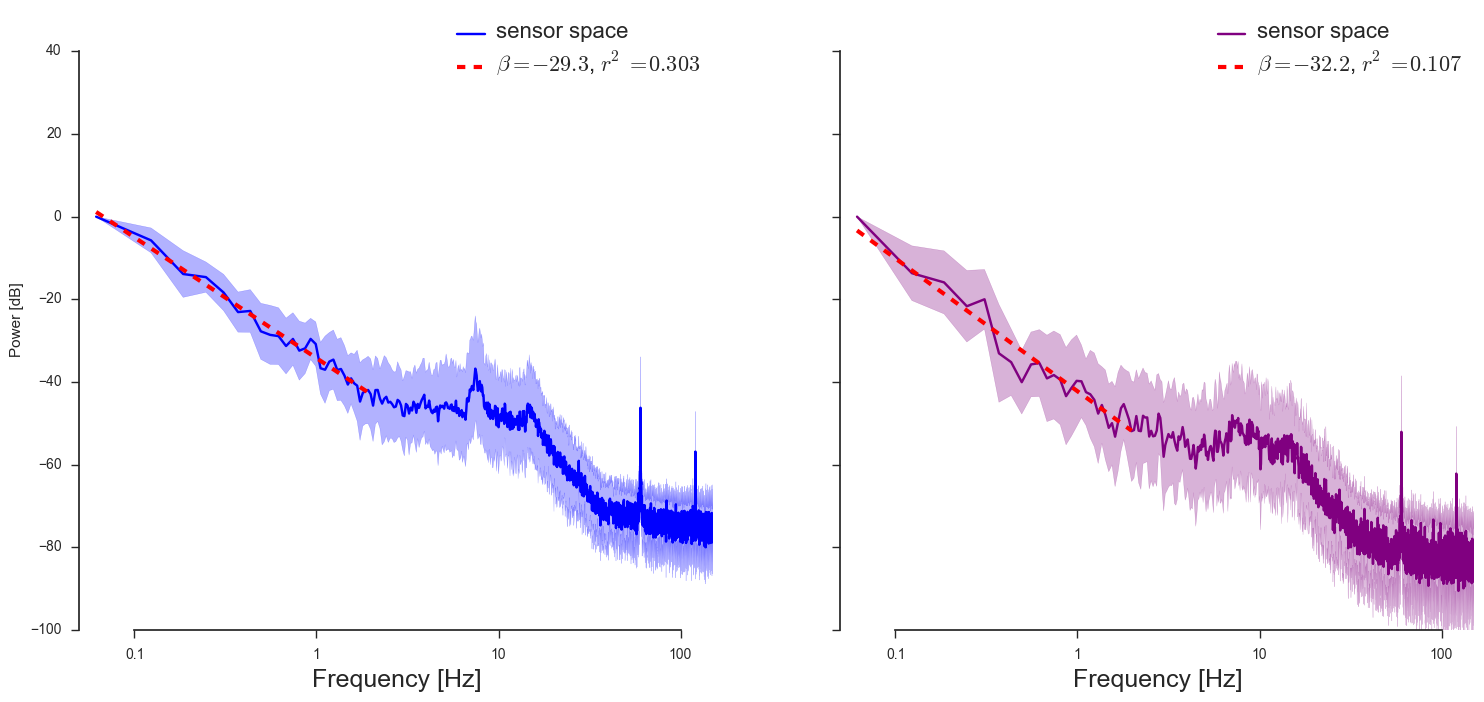

In [83]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharex=True, sharey=True)
axes = axes.ravel()

n_fft = 2 ** 15
decim = 1
duration = n_fft * (1. / raw.info['sfreq'])
events = mne.make_fixed_length_events(raw, 42, duration=duration)
epochs = mne.Epochs(raw, events=events[up_state], event_id=42, tmin=0,
                    tmax=duration, baseline=None, preload=True, decim=decim)

psd_epochs1, freqs = mne.time_frequency.psd_welch(epochs, n_fft=n_fft, n_overlap=0)
psd = psd_epochs1.mean(0)

psd, freqs = clean_psd(psd, freqs)

psd_mean = psd.mean(0)
psd_std = psd.std(0)

fmask = (freqs > 0) & (freqs < 2)


ax = axes[0]
ax.plot(np.log10(freqs), psd_mean, label='sensor space', color='blue')
ax.fill_between(np.log10(freqs),
                 psd_mean + psd_std,
                 psd_mean - psd_std, alpha=0.3, color='blue')

lm = LinearRegression(normalize=False).fit(
   np.log10(freqs[fmask][:, None]), psd.T[fmask])
scores = [r2_score(x, y) for x, y in zip(
          lm.predict(np.log10(freqs[fmask])[:, None]), psd.T[fmask])]
fit_line = lm.predict(np.log10(freqs[fmask][:, None])).mean(1)
ax.plot(np.log10(freqs[fmask]), fit_line, color='red', linewidth=3,
        linestyle='--', label=r"$\beta=%0.1f$, $r^2=%0.3f$" % (
            lm.coef_.ravel().mean(0), np.mean(scores)))

ax.set_xlim(*np.log10([0.05, 150]))
ax.set_xticks(np.log10([0.1, 1, 10, 100]))
ax.set_xticklabels([0.1, 1, 10, 100])
for tt in ax.legend().get_texts():
    tt.set_fontsize(16)
    
###

events = mne.make_fixed_length_events(raw, 42, duration=duration)
epochs = mne.Epochs(raw, events=events[down_state], event_id=42, tmin=0,
                    tmax=duration, baseline=None, preload=True, decim=decim)

psd_epochs2, freqs = mne.time_frequency.psd_welch(epochs, n_fft=n_fft, n_overlap=0)
psd = psd_epochs2.mean(0)

psd, freqs = clean_psd(psd, freqs)

psd_mean = psd.mean(0)
psd_std = psd.std(0)

fmask = (freqs > 0) & (freqs < 2)


ax = axes[1]
ax.plot(np.log10(freqs), psd_mean, label='sensor space', color='purple')
ax.fill_between(np.log10(freqs),
                 psd_mean + psd_std,
                 psd_mean - psd_std, alpha=0.3, color='purple')

lm = LinearRegression(normalize=False).fit(
   np.log10(freqs[fmask][:, None]), psd.T[fmask])
scores = [r2_score(x, y) for x, y in zip(
          lm.predict(np.log10(freqs[fmask])[:, None]), psd.T[fmask])]
fit_line = lm.predict(np.log10(freqs[fmask][:, None])).mean(1)
ax.plot(np.log10(freqs[fmask]), fit_line, color='red', linewidth=3,
        linestyle='--', label=r"$\beta=%0.1f$, $r^2=%0.3f$" % (
            lm.coef_.ravel().mean(0), np.mean(scores)))

ax.set_xlim(*np.log10([0.05, 150]))
ax.set_xticks(np.log10([0.1, 1, 10, 100]))
ax.set_xticklabels([0.1, 1, 10, 100])
for tt in ax.legend().get_texts():
    tt.set_fontsize(16)
    
axes[0].set_ylabel('Power [dB]')
axes[0].set_xlabel('Frequency [Hz]', fontsize=18)
axes[1].set_xlabel('Frequency [Hz]', fontsize=18)
axes[0].set_ylim(-100, 50)
axes[1].set_ylim(-100, 50)
sns.despine(trim=True)

fig.savefig('paper_figures/compare_alpha_down_up.png', dpi=600)

### yet a contrast does not directly reveal a clear peak difference on single run

my suspicion is that 16 second windows are too long to allow clear grouping by alpha power

In [301]:
aa, bb = psd_epochs1.mean(0), psd_epochs2.mean(0)
aa = np.log10(aa / aa[:, 0:1])                   
bb = np.log10(bb / bb[:, 0:1])
                                       
plt.plot(np.log10(freqs), (aa - bb).T[1:].mean(1));
plt.xlim(np.log10([0.05, 100]))
plt.xticks(np.log10([0.1, 1, 10, 100]), [0.1, 1, 10, 100])

NameError: name 'psd_epochs1' is not defined

In [171]:
def get_up_down_inds(raw):
    n_fft = 2 ** 15
    decim = 1
    duration = n_fft * (1. / raw.info['sfreq'])
    events = mne.make_fixed_length_events(raw, 42, duration=duration)
    epochs = mne.Epochs(raw, events=events, event_id=42, tmin=0,
                        tmax=duration, baseline=None, preload=True, decim=decim)

    psd_epochs, freqs = mne.time_frequency.psd_welch(epochs, n_fft=n_fft, n_overlap=0)
    fmask = (freqs > 8) & (freqs < 12)
    means = np.log10(psd_epochs[:, :,  fmask]).mean(-1).mean(1)
    med = np.median(means)
    up_state = means > med
    down_state = np.invert(up_state)
    return up_state, down_state

psd_up, psd_down = 0.0, 0.0
for run in range(3):
    fname = op.join(recordings_path, subject, 'rest-run%i-preproc-raw.fif' % run)
    raw = mne.io.read_raw_fif(fname)
    raw.load_data()
    raw.interpolate_bads()
    up_state, down_state = get_up_down_inds(raw)
    print('%i up -- %i down' % (sum(up_state), sum(down_state)))
    n_fft = 2 ** 15
    decim = 1
    duration = n_fft * (1. / raw.info['sfreq'])
    events = mne.make_fixed_length_events(raw, 42, duration=duration)
    epochs = mne.Epochs(raw, events=events[up_state], event_id=42, tmin=0,
                        tmax=duration, baseline=None, preload=True, decim=decim)

    psd_epochs1, freqs = mne.time_frequency.psd_welch(epochs, n_fft=n_fft, n_overlap=0)
    psd_up += psd_epochs1.mean(0)
    
    epochs = mne.Epochs(raw, events=events[down_state], event_id=42, tmin=0,
                        tmax=duration, baseline=None, preload=True, decim=decim)

    psd_epochs2, freqs = mne.time_frequency.psd_welch(epochs, n_fft=n_fft, n_overlap=0)    
    psd_down += psd_epochs2.mean(0)
psd_up /= 3
psd_down /=3


Opening raw data file /mnt/hcp-meg/105923/rest-run0-preproc-raw.fif...
Isotrak not found
    Range : 0 ... 749069 =      0.000 ...   368.182 secs
Ready.
Current compensation grade : 0
Annotation expanding outside the data range. Limiting to the end of data.
Reading 0 ... 749069  =      0.000 ...   368.182 secs...


<ipython-input-171-398cb7cec110>:20: RuntimeWarning: Annotation expanding outside the data range. Limiting to the end of data.
  raw = mne.io.read_raw_fif(fname)


    Computing dot products for 245 coils...
    Computing cross products for coils 245 x 3 coils...
    Preparing the mapping matrix...
    [Truncate at 81 missing 0.0001]
22 matching events found
No baseline correction applied
0 projection items activated
Loading data for 22 events and 32769 original time points ...
9 bad epochs dropped
Effective window size : 16.106 (s)
6 up -- 7 down
6 matching events found
No baseline correction applied
0 projection items activated
Loading data for 6 events and 32769 original time points ...
1 bad epochs dropped
Effective window size : 16.106 (s)
7 matching events found
No baseline correction applied
0 projection items activated
Loading data for 7 events and 32769 original time points ...
5 bad epochs dropped
Effective window size : 16.106 (s)
Opening raw data file /mnt/hcp-meg/105923/rest-run1-preproc-raw.fif...
Isotrak not found
    Range : 0 ... 765715 =      0.000 ...   376.363 secs
Ready.
Current compensation grade : 0
Annotation expanding out

<ipython-input-171-398cb7cec110>:20: RuntimeWarning: Annotation expanding outside the data range. Limiting to the end of data.
  raw = mne.io.read_raw_fif(fname)


    Computing dot products for 242 coils...
    Computing cross products for coils 242 x 6 coils...
    Preparing the mapping matrix...
    [Truncate at 80 missing 0.0001]
23 matching events found
No baseline correction applied
0 projection items activated
Loading data for 23 events and 32769 original time points ...
10 bad epochs dropped
Effective window size : 16.106 (s)
6 up -- 7 down
6 matching events found
No baseline correction applied
0 projection items activated
Loading data for 6 events and 32769 original time points ...
4 bad epochs dropped
Effective window size : 16.106 (s)
7 matching events found
No baseline correction applied
0 projection items activated
Loading data for 7 events and 32769 original time points ...
4 bad epochs dropped
Effective window size : 16.106 (s)
Opening raw data file /mnt/hcp-meg/105923/rest-run2-preproc-raw.fif...
Isotrak not found
    Range : 0 ... 748663 =      0.000 ...   367.982 secs
Ready.
Current compensation grade : 0
Annotation expanding ou

<ipython-input-171-398cb7cec110>:20: RuntimeWarning: Annotation expanding outside the data range. Limiting to the end of data.
  raw = mne.io.read_raw_fif(fname)


    Computing dot products for 246 coils...
    Computing cross products for coils 246 x 2 coils...
    Preparing the mapping matrix...
    [Truncate at 80 missing 0.0001]
22 matching events found
No baseline correction applied
0 projection items activated
Loading data for 22 events and 32769 original time points ...
8 bad epochs dropped
Effective window size : 16.106 (s)
7 up -- 7 down
7 matching events found
No baseline correction applied
0 projection items activated
Loading data for 7 events and 32769 original time points ...
3 bad epochs dropped
Effective window size : 16.106 (s)
7 matching events found
No baseline correction applied
0 projection items activated
Loading data for 7 events and 32769 original time points ...
2 bad epochs dropped
Effective window size : 16.106 (s)


In [119]:
psd_down.shape

(248, 16385)

In [120]:
freqs.shape

(16385,)

In [139]:
from astropy.convolution import convolve, Gaussian1DKernel

gauss_kernel = Gaussian1DKernel(10)  # 0.5 Hz bandwidth
# smoothed_data_gauss = np.array([convolve(pp, gauss_kernel) for pp in np.diff(psd, axis=-1)])


/home/ubuntu/miniconda2/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/home/ubuntu/miniconda2/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10


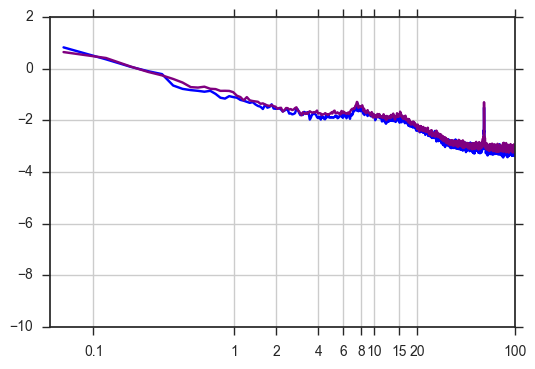

In [170]:
aa, bb = psd_up, psd_down
aa = np.log10(aa / aa[:, 0:1])                   
bb = np.log10(bb / bb[:, 0:1])
                                       

# plt.plot(np.log10(freqs), convolve((aa - bb).T.mean(1), gauss_kernel))
plt.plot(np.log10(freqs), bb.T.mean(1), color='blue');
plt.plot(np.log10(freqs), aa.T.mean(1), color='purple');
plt.xlim(np.log10([0.05, 100]))
ticks = [0.1, 1, 2, 4, 6, 8, 10, 15, 20, 100]
plt.xticks(np.log10(ticks), ticks)
plt.grid(True)

# Detrended Fluctuation Analysis

In [65]:
# author: Dominik Krzeminski (dokato)

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ss

# detrended fluctuation analysis

def calc_rms(x, scale):
    """
    Root Mean Square in windows with linear detrending.
    
    Args:
    -----
      *x* : numpy.array
        one dimensional data vector
      *scale* : int
        length of the window in which RMS will be calculaed
    Returns:
    --------
      *rms* : numpy.array
        RMS data in each window with length len(x)//scale
    """
    # making an array with data divided in windows
    shape = (x.shape[0] // scale, scale)
    X = np.lib.stride_tricks.as_strided(x, shape=shape)
    # vector of x-axis points to regression
    scale_ax = np.arange(scale)
    rms = np.zeros(X.shape[0])
    for e, xcut in enumerate(X):
        coeff = np.polyfit(scale_ax, xcut, 1)
        xfit = np.polyval(coeff, scale_ax)
        # detrending and computing RMS of each window
        rms[e] = np.sqrt(np.mean((xcut - xfit) ** 2))
    return rms

def dfa(x, scales, show=False):
    # cumulative sum of data with substracted offset
    y = np.cumsum(x - np.mean(x))
    fluct = np.zeros(len(scales))
    # computing RMS for each window
    for e, sc in enumerate(scales):
        fluct[e] = np.mean(np.sqrt(calc_rms(y, sc)**2))
    
    return fluct

In [25]:
raw.interpolate_bads()

    Computing dot products for 245 coils...
    Computing cross products for coils 245 x 3 coils...
    Preparing the mapping matrix...
    [Truncate at 81 missing 0.0001]


<Raw  |  rest-run0-preproc-raw.fif, n_channels x n_times : 248 x 749070 (368.2 sec), ~1.38 GB, data loaded>

In [26]:
# fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharex=True, sharey=True)
# axes = axes.ravel()
n_fft = 2 ** 15
decim = 1
duration = n_fft * (1. / raw.info['sfreq'])
events = mne.make_fixed_length_events(raw, 42, duration=duration)
epochs = mne.Epochs(raw, events=events, event_id=42, tmin=0,
                    tmax=duration, baseline=None, preload=True, decim=decim)

psd_epochs, freqs = mne.time_frequency.psd_welch(epochs, n_fft=n_fft, n_overlap=0)

psd = psd_epochs.mean(0)

psd, freqs = clean_psd(psd, freqs)


22 matching events found
No baseline correction applied
0 projection items activated
Loading data for 22 events and 32769 original time points ...
9 bad epochs dropped
Effective window size : 16.106 (s)


In [227]:
scales = np.floor(2.0 ** np.arange(4, 15, 1.)).astype(int)
scales

array([   16,    32,    64,   128,   256,   512,  1024,  2048,  4096,
        8192, 16384])

In [228]:
scales / epochs.info['sfreq']

array([  7.86430097e-03,   1.57286019e-02,   3.14572039e-02,
         6.29144077e-02,   1.25828815e-01,   2.51657631e-01,
         5.03315262e-01,   1.00663052e+00,   2.01326105e+00,
         4.02652210e+00,   8.05304419e+00])

In [229]:
fluct = np.array([dfa(ch, scales) for ch in np.hstack(epochs.get_data())])

In [231]:
lm_fluct = LinearRegression().fit(
    np.log10(scales)[:, None], np.log10(fluct.T))


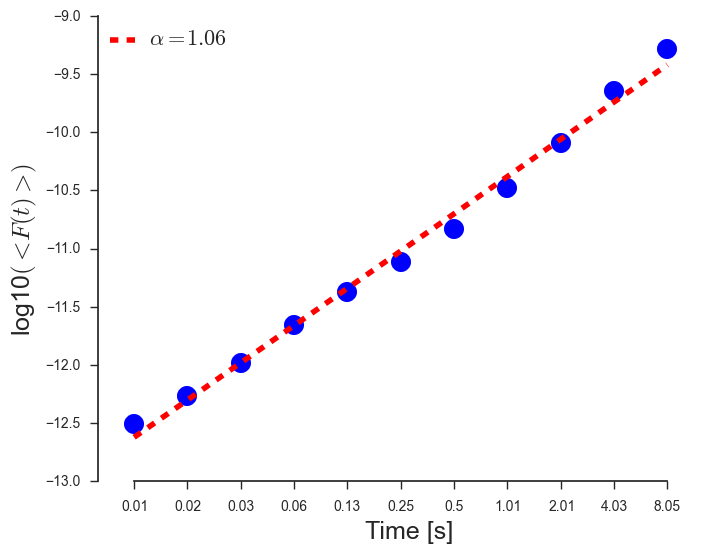

In [285]:
fig = plt.figure(figsize=(8, 6))

lm = LinearRegression().fit(
    np.log10(scales)[:, None], np.log10(fluct[0][:, None]))
fluct_fit = lm.predict(np.log10(scales[:, None]))

plt.plot(np.log10(scales), np.log10(fluct[0]), color='blue', linewidth=4, linestyle='None', marker='o',
         markersize=15)
plt.plot(np.log10(scales), fluct_fit, color='red', linestyle='--', linewidth=4, label=r'$\alpha=%0.2f$' % lm.coef_)
plt.xticks(np.log10(scales),
           np.round(scales / epochs.info['sfreq'], 2))
plt.xlabel('Time [s]', fontsize=18)
plt.ylabel(r'log10$(<F(t)>)$', fontsize=18)
for tt in plt.legend(loc='best').get_texts():
    tt.set_fontsize(16)
sns.despine(trim=True)
fig.savefig('./paper_figures/dfa_demo.png', dpi=600)

In [280]:
lm = LinearRegression(normalize=False).fit(
   np.log10(freqs[fmask][:, None]), psd.T[fmask])
scores = [r2_score(x, y) for x, y in zip(
          lm.predict(np.log10(freqs[fmask])[:, None]), psd.T[fmask])]

In [281]:
fluct_coefs = lm_fluct.coef_[:, 0].tolist()

In [282]:
np.corrcoef(lm.coef_[:, 0], fluct_coefs)

array([[ 1.        , -0.70305005],
       [-0.70305005,  1.        ]])

In [283]:
rr = np.corrcoef(lm.coef_[:, 0].tolist(), fluct_coefs)[:, 0][1]

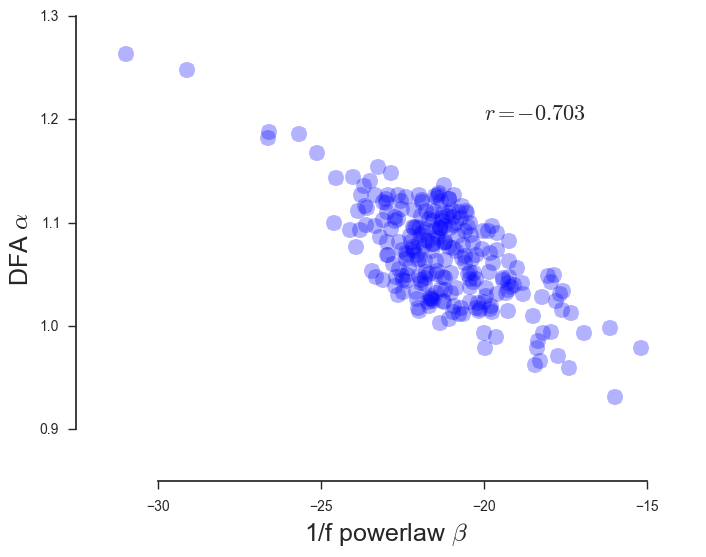

In [284]:
fig = plt.figure(figsize=(8, 6))
plt.plot(
    lm.coef_[:, 0].tolist(), fluct_coefs, linestyle='None', marker='o', color='blue', alpha=0.3,
    markersize=12)
plt.xlim(-32.5, -13.5)
plt.ylim(0.85, 1.3)
plt.xlabel(r'1/f powerlaw $\beta$', fontsize=18)
plt.ylabel(r'DFA $\alpha$', fontsize=18)
plt.annotate(r'$r=%0.3f$' % rr, xy=(-20, 1.2), fontsize=16)
sns.despine(trim=True)
fig.savefig('./paper_figures/dfa_vs_beta.png', dpi=600)

(16384,)

In [294]:
psd_epochs, freqs = mne.time_frequency.psd_welch(epochs, n_fft=n_fft, n_overlap=0, fmax=110)


Effective window size : 16.106 (s)


In [295]:
freqs.shape

(1772,)

In [300]:
assert np.all(freqs == np.arange(0, 110, epochs.info['sfreq'] / n_fft))